In [ ]:
import diffupy
import networkx
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import scipy
from scipy import stats
import random
import numpy as np
from sklearn import neighbors
from scipy.stats import norm, gaussian_kde
from networkx import algorithms
from scipy.special import ndtr
from numpy.polynomial import Polynomial
import itertools

## Load network and phospho data

In [2]:
network_dataframe = pd.read_csv("data/BIOGRID-PUBLICATION-13022-4.1.190.tab3.txt", sep='\t')

In [3]:
network_dataframe.columns

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Publication Source',
       'Organism ID Interactor A', 'Organism ID Interactor B', 'Throughput',
       'Score', 'Modification', 'Qualifications', 'Tags', 'Source Database',
       'SWISS-PROT Accessions Interactor A', 'TREMBL Accessions Interactor A',
       'REFSEQ Accessions Interactor A', 'SWISS-PROT Accessions Interactor B',
       'TREMBL Accessions Interactor B', 'REFSEQ Accessions Interactor B',
       'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories',
       'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names',
       'Ontology

In [4]:
phospho_dataframe = pd.read_csv("data/final_ascored_pep_tgr09076_09614.csv")

In [5]:
phospho_dataframe

,Uniprot ID,FlyBase ID,Gene name,PeptideSequence (Ascore >= 13),log2 fold change,negative_log_one_minus_prob,Nuclear cycle 14 parent protein conc. (uM) (some proteins not measured),prob,1-prob,log(1+-log(1-p)),Unnamed: 10,Non-outlier concentration,log non-outlier concentration
0,X2JI50,FBgn0003159,CG2841,R.SEASQQS#PTPVPK.K,-0.218262,0.686956,0.000634,0.378837,0.621163,0.836929,NaN,0.000634,-3.198120
1,X2JI50,FBgn0003159,CG2841,K.VLLNRT#PT#PEPR.S,0.554219,1.449185,0.000634,0.633772,0.366228,1.161124,NaN,0.000634,-3.198120
2,X2JF73,FBgn0030674,HUWE1,R.RDNS#SDGATGAGSIVYR.A,0.067819,0.411179,0.059093,0.247992,0.752008,0.614031,NaN,0.059093,-1.228465
3,X2JF73,FBgn0030674,HUWE1,K.SQSGGS#PPIPK.R,0.001298,0.304538,0.059093,0.190298,0.809702,0.483641,NaN,0.059093,-1.228465
4,X2JF73,FBgn0030674,HUWE1,K.S#QSGGS#PPIPK.R,0.000433,0.301569,0.059093,0.188630,0.811370,0.479386,NaN,0.059093,-1.228465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,A0A0B4JD97,FBgn0026620,tacc,K.ERQAPISNS#PPIPTHQR.L,0.076192,0.507541,0.296167,0.296580,0.703420,0.705471,NaN,0.296167,-0.528463
4347,A0A0B4JD97,FBgn0026620,tacc,K.EQATLS#AS#DEK.D,0.402212,1.173277,0.296167,0.556587,0.443413,1.069401,NaN,0.296167,-0.528463
4348,A0A0B4JD97,FBgn0026620,tacc,K.EQAT#LS#ASDEK.D,0.238151,0.826755,0.296167,0.436204,0.563796,0.917377,NaN,0.296167,-0.528463
4349,A0A023GRW3,FBgn0031319,CG4896,R.RCS#S#DEDSDMASEFR.Q,0.395448,0.906144,0.001200,0.466391,0.533609,0.957197,NaN,0.001200,-2.920872


In [6]:
phospho_names = set(phospho_dataframe['Gene name'])
network_names = set(network_dataframe['Official Symbol Interactor A']) | set(network_dataframe['Official Symbol Interactor B']) 
common = phospho_names & network_names

print("Common gene names: {}, out of {} in phospho data and {} in network".format(len(common), len(phospho_names), 
                                                                                  len(network_names)))

Common gene names: 951, out of 1595 in phospho data and 6732 in network


In [7]:
network_dataframe = network_dataframe[['Official Symbol Interactor A', 'Official Symbol Interactor B']]

In [8]:
ppi = networkx.from_pandas_edgelist(network_dataframe, 'Official Symbol Interactor A',  
                                    'Official Symbol Interactor B').to_undirected()

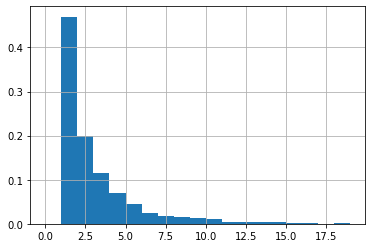

In [9]:
phospho_measure = 'log2 fold change' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

phospho_dataframe.groupby('Gene name')[phospho_measure].count().hist(bins=range(20), density=True)

In [10]:
networkx.set_node_attributes(ppi, dict(phospho_measure_values), phospho_measure)

## Test centrality v.s. fold change

In [11]:
closeness_centrality = networkx.closeness_centrality(ppi)
betweenness_centrality = networkx.betweenness_centrality(ppi)
degree_centrality = networkx.degree_centrality(ppi)

In [12]:
x, y = zip(*[(closeness_centrality[gene_name], betweenness_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))
x, y = zip(*[(closeness_centrality[gene_name], degree_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))
x, y = zip(*[(degree_centrality[gene_name], betweenness_centrality[gene_name]) for gene_name in common])
print(scipy.stats.spearmanr(x, y, nan_policy='omit'))


SpearmanrResult(correlation=0.8278346601737859, pvalue=1.739196308467747e-240)
SpearmanrResult(correlation=0.8709112797943337, pvalue=4.773200411025748e-295)
SpearmanrResult(correlation=0.9526819789879247, pvalue=0.0)


In [13]:
phospho_measure = 'log2 fold change' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

In [14]:
# Spearman correlation
centrality_measure = closeness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=0.01567070362907561, pvalue=0.6293430458808142)

In [15]:
# Spearman correlation
centrality_measure = betweenness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=-0.028989083095221902, pvalue=0.37186488098265047)

In [16]:
# Spearman correlation
centrality_measure = degree_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=0.002300924758765903, pvalue=0.9435065111045666)

In [17]:
phospho_measure = 'Non-outlier concentration' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.groupby('Gene name')[phospho_measure].mean()

In [18]:
# Spearman correlation
centrality_measure = closeness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=0.02542338876672692, pvalue=0.4623502465386954)

In [19]:
# Spearman correlation
centrality_measure = betweenness_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=0.06915878831573685, pvalue=0.045345759198447765)

In [20]:
# Spearman correlation
centrality_measure = degree_centrality
x, y = zip(*[(phospho_measure_values[gene_name], centrality_measure[gene_name]) for gene_name in common])
scipy.stats.spearmanr(x, y, nan_policy='omit')

SpearmanrResult(correlation=0.05099748585474002, pvalue=0.14020093024708355)

## Up/Down analysis

In [ ]:
def get_up_down_sets(data, significance_mode, significance_threshold):
    if significance_mode == "value":
        up_proteins = data[data > significance_threshold]
        down_proteins = data[data < -significance_threshold]
    elif significance_mode == "std":
        std = np.std(data)
        mean = np.mean(data)
        up_proteins = data[(data - mean) / std > significance_threshold]
        down_proteins = data[(data - mean) / std < -significance_threshold]
    print("overactivated proteins: {}, underactivated proteins: {}, rest: {}".format(len(up_proteins), 
        len(down_proteins), len(data) - len(up_proteins) - len(down_proteins)))
    return up_proteins, down_proteins

### Individual node scores

In [229]:
def metric_prot_scores(metric, proteins):
    return [metric[p] for p in proteins]

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='value', significance_threshold=0)
up_metric = metric_prot_scores(closeness_centrality, up_proteins.index)
down_metric = metric_prot_scores(closeness_centrality, down_proteins.index)
total_metric = metric_prot_scores(closeness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for closeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(betweenness_centrality, up_proteins.index)
down_metric = metric_prot_scores(betweenness_centrality, down_proteins.index)
total_metric = metric_prot_scores(betweenness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for betweeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(degree_centrality, up_proteins.index)
down_metric = metric_prot_scores(degree_centrality, down_proteins.index)
total_metric = metric_prot_scores(degree_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for degree centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

overactivated proteins: 584, underactivated proteins: 367, rest: 0
metric means: up: 2.25e-01, down: 2.23e-01, total: 2.24e-01
p-values for closeness centrality (against full set): up: 3.79e-01, down: 3.38e-01

metric means: up: 5.71e-04, down: 6.07e-04, total: 5.85e-04
p-values for betweeness centrality (against full set): up: 4.09e-01, down: 3.77e-01

metric means: up: 1.03e-03, down: 9.64e-04, total: 1.00e-03
p-values for degree centrality (against full set): up: 4.73e-01, down: 4.64e-01


In [230]:
def metric_prot_scores(metric, proteins):
    return [metric[p] for p in proteins]

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='std', significance_threshold=2)
up_metric = metric_prot_scores(closeness_centrality, up_proteins.index)
down_metric = metric_prot_scores(closeness_centrality, down_proteins.index)
total_metric = metric_prot_scores(closeness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for closeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(betweenness_centrality, up_proteins.index)
down_metric = metric_prot_scores(betweenness_centrality, down_proteins.index)
total_metric = metric_prot_scores(betweenness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for betweeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(degree_centrality, up_proteins.index)
down_metric = metric_prot_scores(degree_centrality, down_proteins.index)
total_metric = metric_prot_scores(degree_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for degree centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

overactivated proteins: 11, underactivated proteins: 35, rest: 905
metric means: up: 2.10e-01, down: 2.35e-01, total: 2.24e-01
p-values for closeness centrality (against full set): up: 4.06e-02, down: 3.70e-02

metric means: up: 4.93e-04, down: 7.93e-04, total: 5.85e-04
p-values for betweeness centrality (against full set): up: 2.01e-01, down: 1.61e-02

metric means: up: 9.72e-04, down: 1.22e-03, total: 1.00e-03
p-values for degree centrality (against full set): up: 2.38e-01, down: 4.02e-02


In [231]:
def metric_prot_scores(metric, proteins):
    return [metric[p] for p in proteins]

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='std', significance_threshold=1)
up_metric = metric_prot_scores(closeness_centrality, up_proteins.index)
down_metric = metric_prot_scores(closeness_centrality, down_proteins.index)
total_metric = metric_prot_scores(closeness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for closeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(betweenness_centrality, up_proteins.index)
down_metric = metric_prot_scores(betweenness_centrality, down_proteins.index)
total_metric = metric_prot_scores(betweenness_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for betweeness centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

print("")

up_metric = metric_prot_scores(degree_centrality, up_proteins.index)
down_metric = metric_prot_scores(degree_centrality, down_proteins.index)
total_metric = metric_prot_scores(degree_centrality, phospho_measure_values.index)
print("metric means: up: {:.2e}, down: {:.2e}, total: {:.2e}".format(np.mean(up_metric), 
                                                                      np.mean(down_metric), 
                                                                      np.mean(total_metric)))
print("p-values for degree centrality (against full set): up: {:.2e}, down: {:.2e}".format(
    stats.mannwhitneyu(up_metric, total_metric)[1], stats.mannwhitneyu(down_metric, total_metric)[1]))

overactivated proteins: 102, underactivated proteins: 108, rest: 741
metric means: up: 2.25e-01, down: 2.25e-01, total: 2.24e-01
p-values for closeness centrality (against full set): up: 4.38e-01, down: 4.48e-01

metric means: up: 5.07e-04, down: 9.77e-04, total: 5.85e-04
p-values for betweeness centrality (against full set): up: 4.85e-01, down: 2.15e-01

metric means: up: 1.04e-03, down: 1.12e-03, total: 1.00e-03
p-values for degree centrality (against full set): up: 2.66e-01, down: 4.76e-01


### Subset scores

In [205]:
def up_down_topological_analysis(up_proteins, down_proteins, topological_metric, random_iter):

    up_value = topological_metric(up_proteins)
    down_value = topological_metric(down_proteins)

    print("Generating up-sized sets")
    up_control_metric_values = []
    for i in range(random_iter):
        random_selection = np.random.choice(list(ppi.nodes.keys()), len(up_proteins))
        control_value = topological_metric(random_selection)
        up_control_metric_values.append(control_value)
        if not (i + 1) % 250:
            print("Checked {} random sets".format(i + 1))
    up_control_average_metric = np.mean(up_control_metric_values)

    print("Generating down-sized sets")
    down_control_metric_values = []
    for i in range(random_iter):
        random_selection = np.random.choice(list(ppi.nodes.keys()), len(down_proteins))
        control_value = topological_metric(random_selection)
        down_control_metric_values.append(control_value)
        if not (i + 1) % 250:
            print("Checked {} random sets".format(i + 1))
    down_control_average_metric = np.mean(down_control_metric_values)
    
    print("up metric v.s. expected: {:.2f}/{:.2f}\ndown metric v.s. expected: {:.2f}/{:.2f}".format(
        up_value, up_control_average_metric, down_value, down_control_average_metric))

    
    plt.figure(figsize=(25, 10))
    plt.subplot(1, 2, 1)
    n, bins, patches = plt.hist(up_control_metric_values, density=True)
    plt.axvline(np.mean(up_control_metric_values), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(up_value, color='r', linestyle='solid', linewidth=1)    
#     loc = np.digitize(up_value, bins)
#     patches[np.clip(loc,  a_min=0, a_max=len(patches) - 1)].set_fc('r')
#     if loc != np.clip(loc, a_min=0, a_max=len(patches) - 1):
#         print("Warning: Up value outside control histogram")
    plt.title("hist for up sized sets:")

    plt.subplot(1, 2, 2)
    n, bins, patches= plt.hist(down_control_metric_values, density=True)
    plt.axvline(np.mean(down_control_metric_values), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(down_value, color='r', linestyle='solid', linewidth=1)    
#     loc = np.digitize(down_value, bins)
#     patches[np.clip(loc,  a_min=0, a_max=len(patches) - 1)].set_fc('r')
#     if loc != np.clip(loc, a_min=0, a_max=len(patches) - 1):
#         print("Warning: Down value outside control histogram")
    plt.title("hist for down sized sets")
    
    plt.show()
    
    # estimate CFG from the density kernel estimator:
#     kde = gaussian_kde(up_control_metric_values)
#     x = np.linspace(min(up_control_metric_values), max(up_control_metric_values), 50)
#     cdf = tuple(ndtr(np.ravel(item - kde.dataset) / kde.factor).mean()
#             for item in x)
#     plt.plot(x, cdf)
#     f = np.poly1d(Polynomial.fit(x, cdf, deg=5))
#     plt.plot(x, f(x))
#     plt.show()
# #     print("double tailed p-value for up (?): {:.2e}".format(min(f(up_value), 1 - f(up_value)) * 2))
    
#     # estimate CFG from the density kernel estimator:
#     kde = gaussian_kde(down_control_metric_values)
#     x = np.linspace(min(down_control_metric_values), max(down_control_metric_values), 50)
#     cdf = tuple(ndtr(np.ravel(item - kde.dataset) / kde.factor).mean()
#             for item in x)
#     plt.plot(x, cdf)
#     f = np.poly1d(Polynomial.fit(x, cdf, deg=5))
#     plt.plot(x, f(x))
#     plt.show()
# #     print("double tailed p-value for down (?): {:.2e}".format(min(f(down_value), 1 - f(down_value)) * 2))

### Degree count

In [206]:
phospho_measure = 'log2 fold change' # 'log2 fold change'
phospho_measure_values = phospho_dataframe.loc[
    phospho_dataframe['Gene name'].isin(common)].groupby('Gene name')[phospho_measure].mean()

overactivated proteins: 584, underactivated proteins: 367, rest: 0
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.48/2.87
down metric v.s. expected: 3.17/2.90


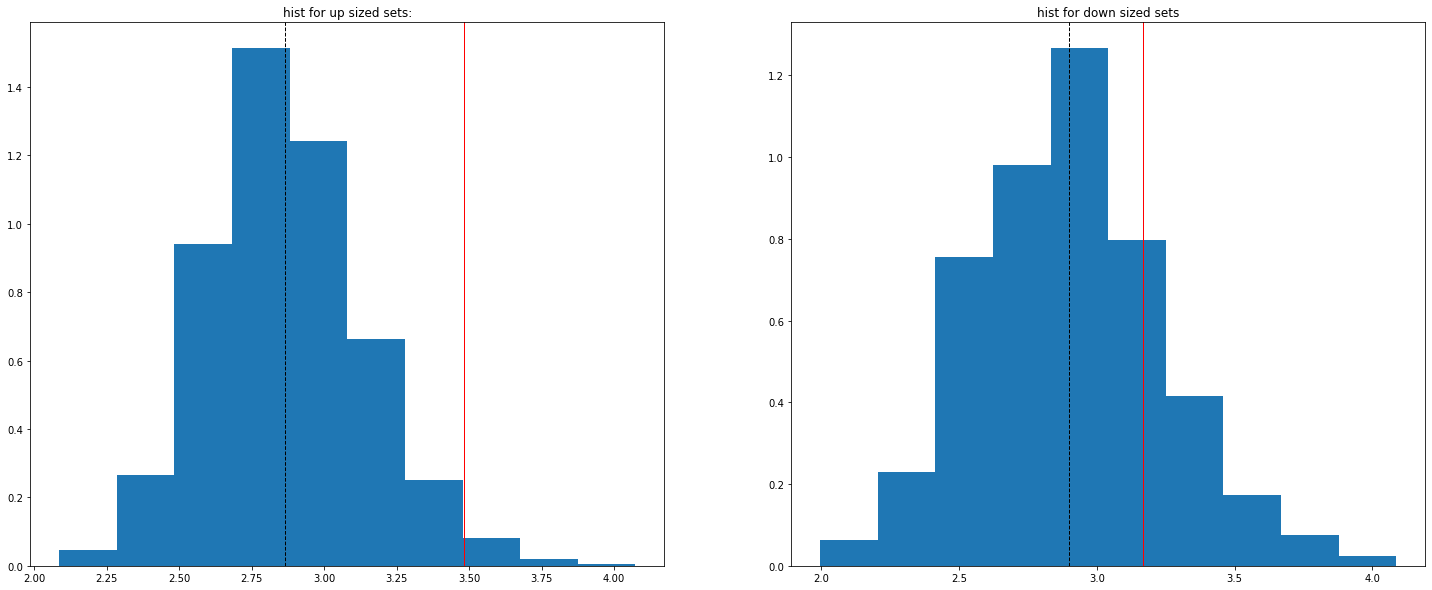

overactivated proteins: 11, underactivated proteins: 35, rest: 905
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.73/2.99
down metric v.s. expected: 3.83/2.96


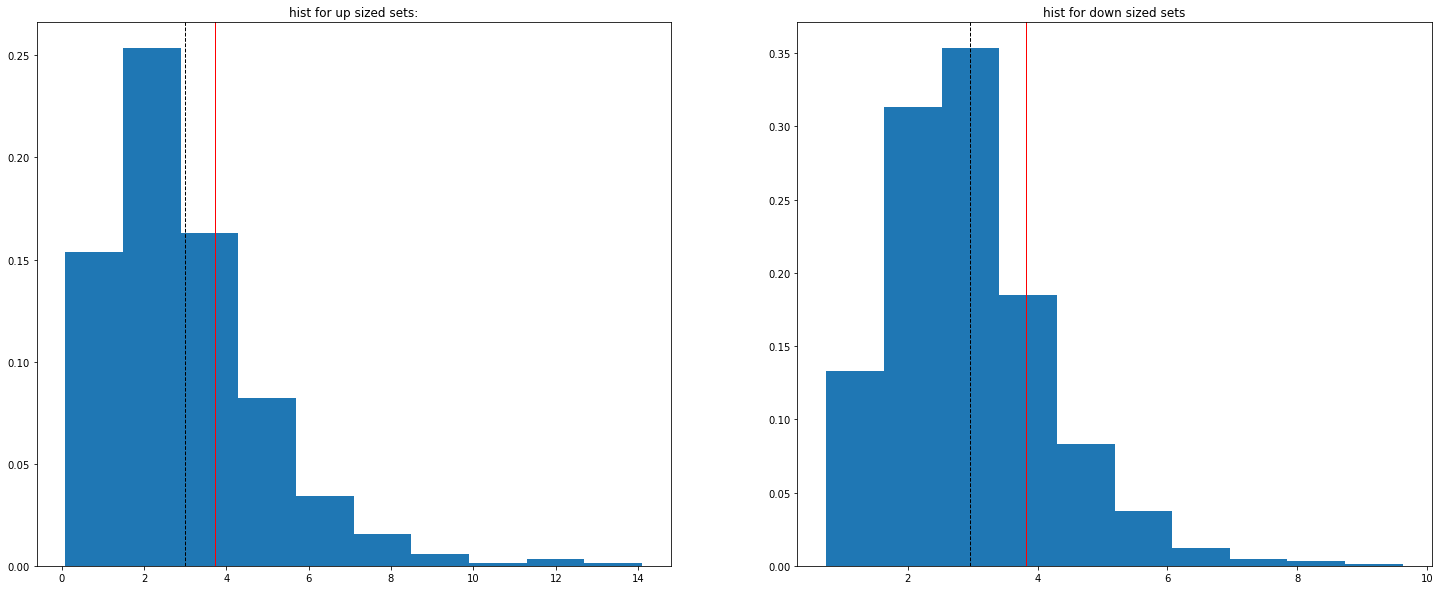

overactivated proteins: 102, underactivated proteins: 108, rest: 741
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.73/2.92
down metric v.s. expected: 3.96/2.96


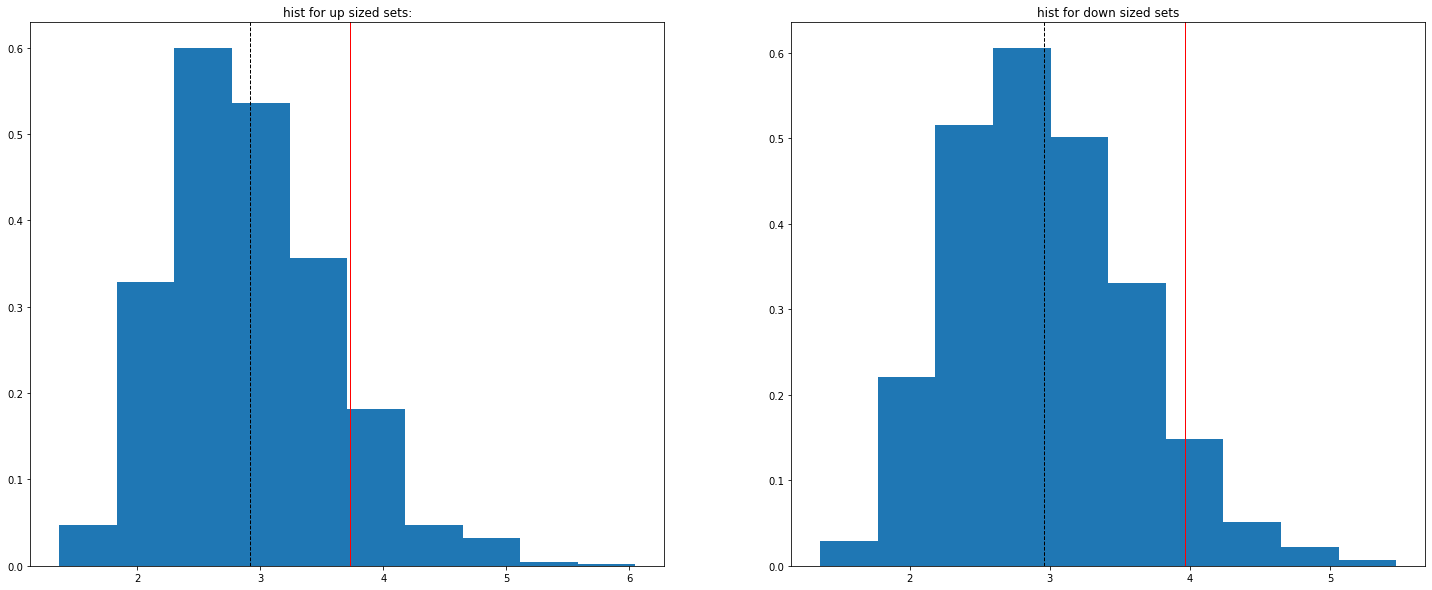

In [208]:
def average_degree(vertices):
    n_degrees = 0
    for (u, v) in ppi.edges():
        if u in vertices:
            n_degrees += 1
    return n_degrees / float(len(vertices))

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='value', significance_threshold=0)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_degree, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='std', significance_threshold=2)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_degree, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='std', significance_threshold=1)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=average_degree, random_iter=1000)


### Edge set count

overactivated proteins: 584, underactivated proteins: 367, rest: 0
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.48/2.86
down metric v.s. expected: 3.17/2.91


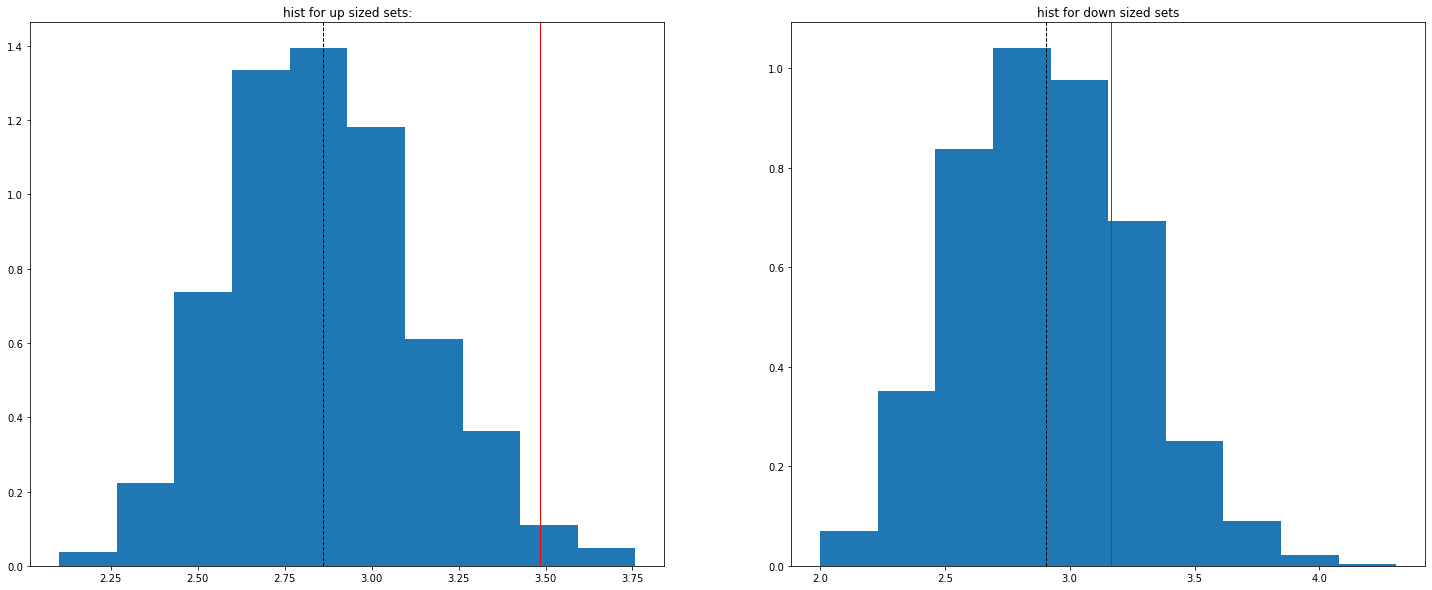

overactivated proteins: 11, underactivated proteins: 35, rest: 905
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.73/3.00
down metric v.s. expected: 3.83/2.95


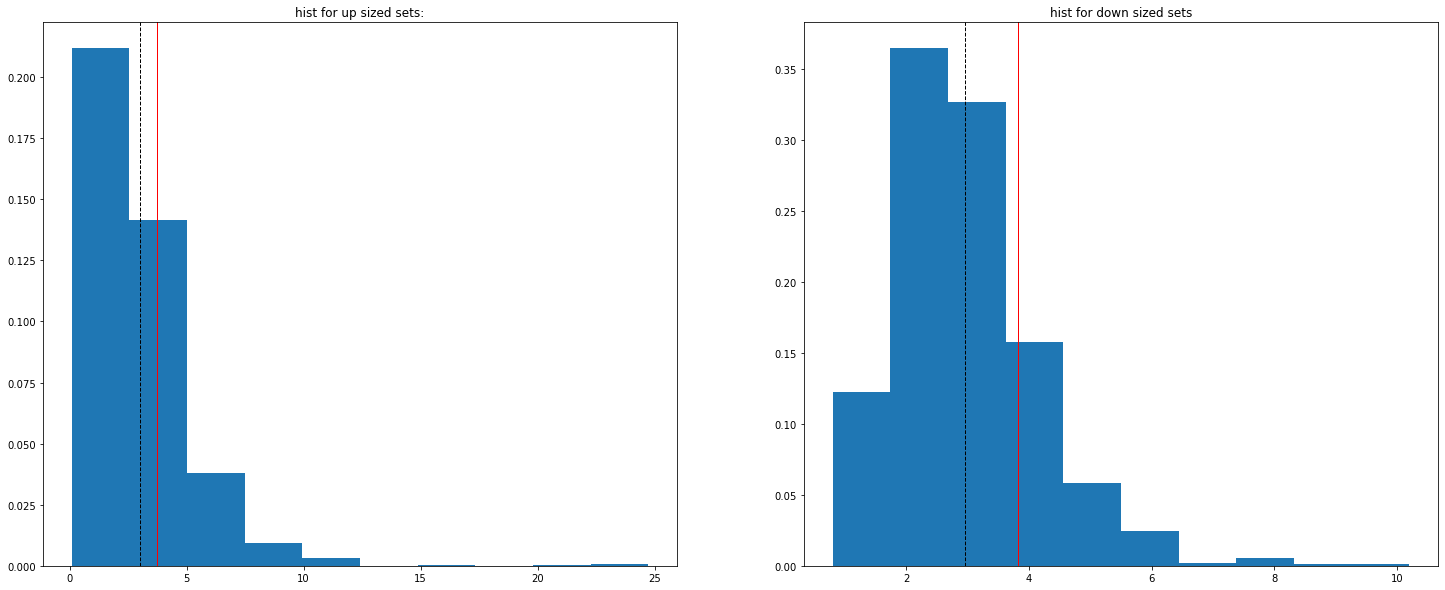

overactivated proteins: 102, underactivated proteins: 108, rest: 741
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.73/2.94
down metric v.s. expected: 3.96/3.00


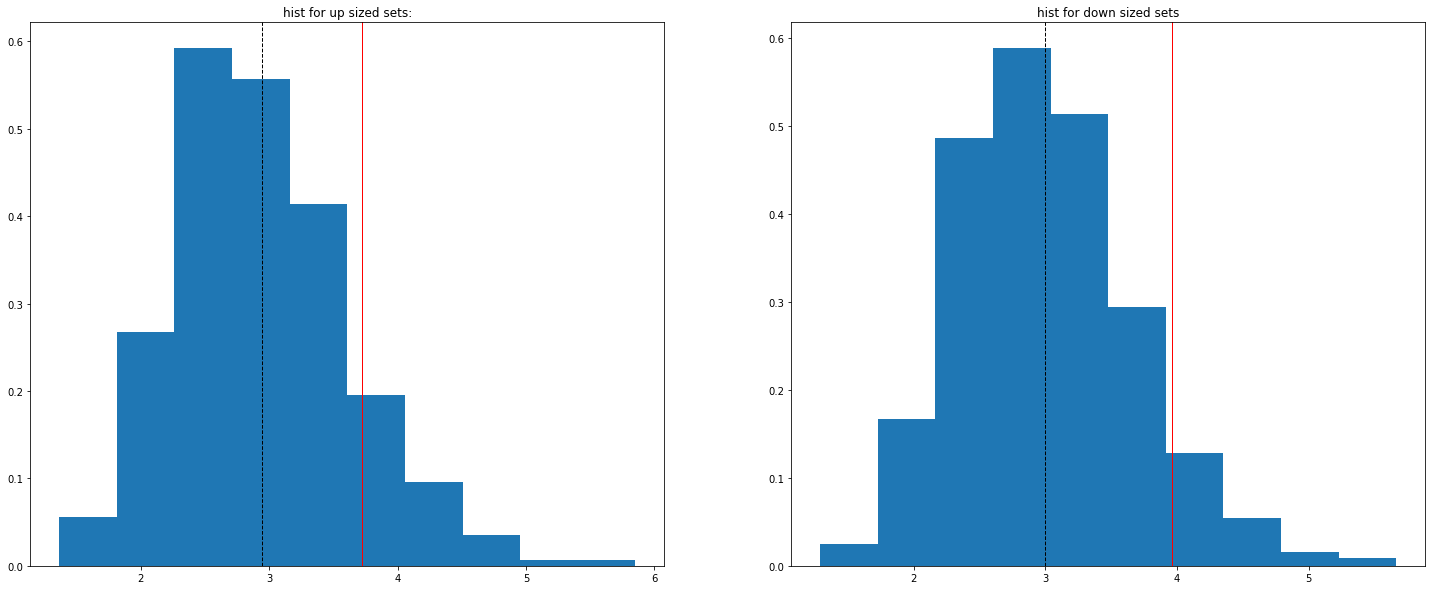

In [209]:
def normalized_edge_set_size(vertices):
    edges = set()
    for (u, v) in ppi.edges():
        if u in vertices and (v, u) not in edges:
            edges.add((u, v))
    return len(edges) / float(len(vertices))

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, significance_mode='value', 
                                              significance_threshold=0)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_edge_set_size, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, significance_mode='std', 
                                              significance_threshold=2)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_edge_set_size, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, significance_mode='std', 
                                              significance_threshold=1)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_edge_set_size, random_iter=1000)


### Neighbor counts

overactivated proteins: 584, underactivated proteins: 367, rest: 0
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 2.54/2.21
down metric v.s. expected: 2.57/2.42


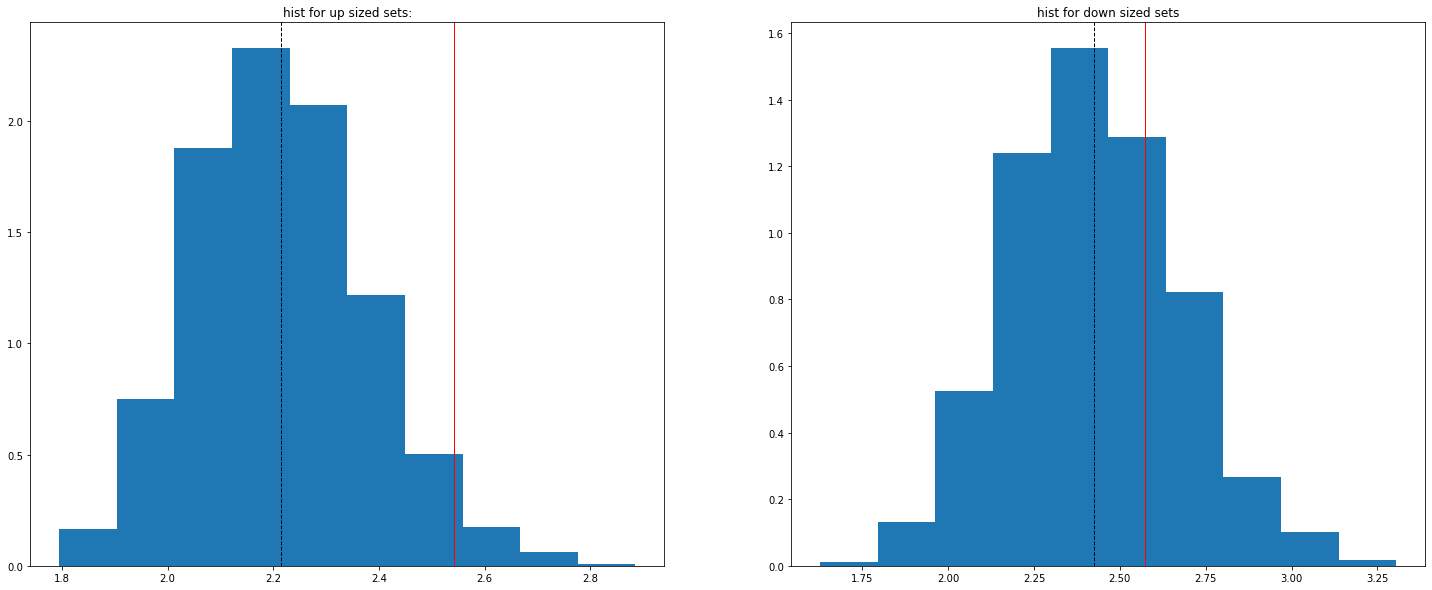

overactivated proteins: 11, underactivated proteins: 35, rest: 905
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.73/2.99
down metric v.s. expected: 3.74/2.91


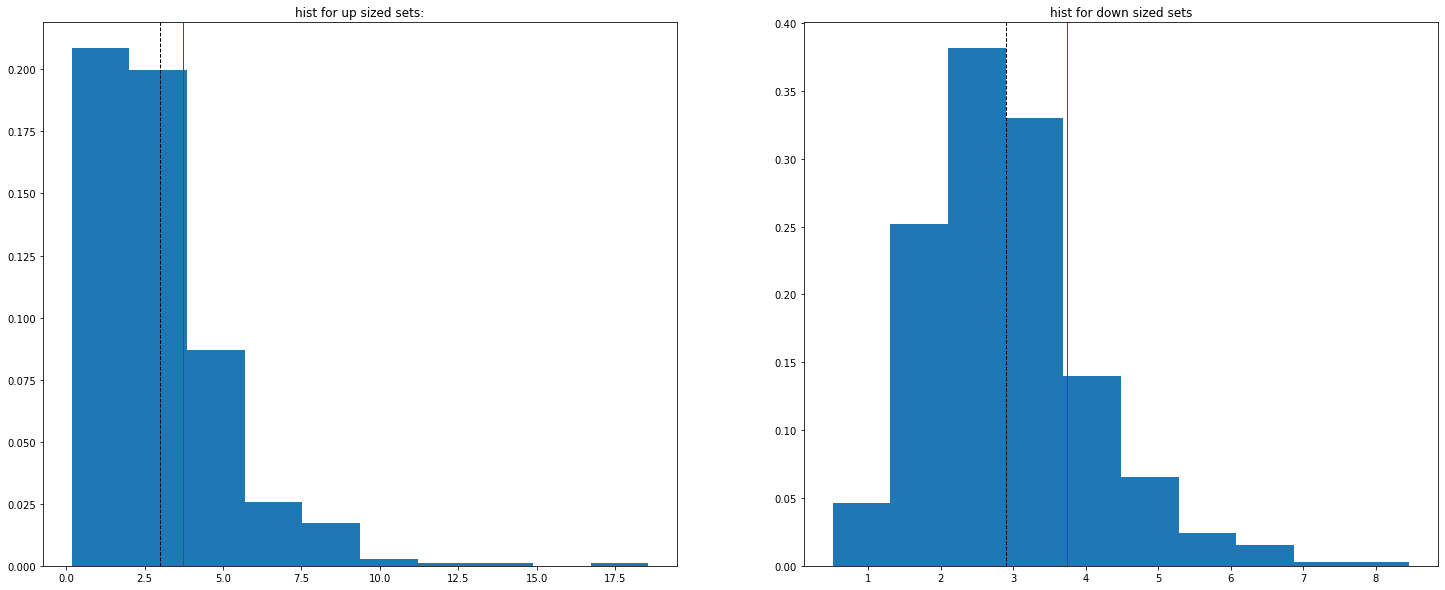

overactivated proteins: 102, underactivated proteins: 108, rest: 741
Generating up-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
Generating down-sized sets
Checked 250 random sets
Checked 500 random sets
Checked 750 random sets
Checked 1000 random sets
up metric v.s. expected: 3.52/2.81
down metric v.s. expected: 3.60/2.76


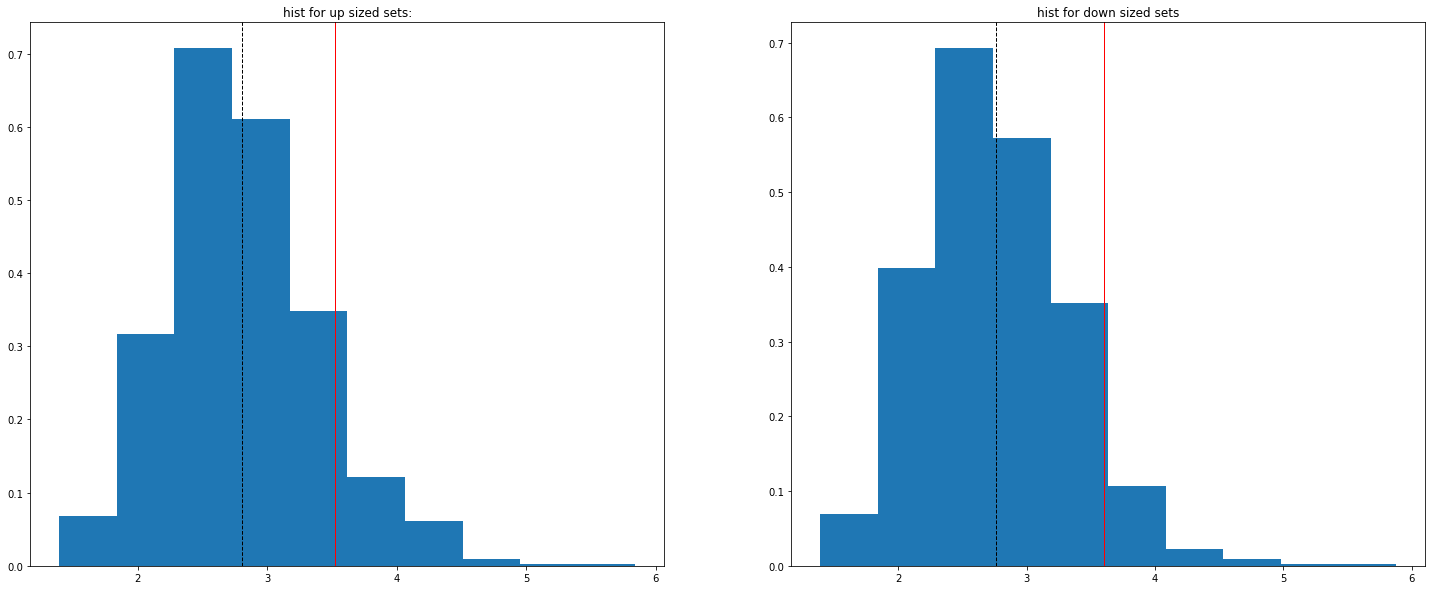

In [211]:
def normalized_neighbor_set_size(vertices):
    neighbors = set()
    for (u, v) in ppi.edges():
        if u in vertices:
            neighbors.add(v)
    return len(neighbors) / float(len(vertices))

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='value', significance_threshold=0)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_neighbor_set_size, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='std', significance_threshold=2)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_neighbor_set_size, random_iter=1000)

up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='std', significance_threshold=1)
up_down_topological_analysis(up_proteins, down_proteins,
                             topological_metric=normalized_neighbor_set_size, random_iter=1000)



### edge pairs analysis

In [212]:
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values, 
                                              significance_mode='value', significance_threshold=0)

def sampled_pair_dist_analysis(data, up_proteins, down_proteins, random_iter, no_path_penalty=1000):
    n_up_pairs = len(up_proteins) * (len(up_proteins) - 1) / 2
    n_down_pairs = len(down_proteins) * (len(down_proteins) - 1) / 2
#     p_up_vs_down = n_up_pairs / float(n_up_pairs + n_down_pairs)
#     p_up = n_up_pairs / float(len(data) * (len(data) - 1) / 2)
#     p_down = n_down_pairs / float(len(data) * (len(data) - 1) / 2)
    
    up_dists = []
    down_dists = []
    opposite_dists = []
    control_dists = []

    for i in range(random_iter):
#         sign_set = up_proteins if random.random() < p_up_vs_down else down_proteins
        up_pair = np.random.choice(up_proteins.index, 2)
        down_pair = np.random.choice(down_proteins.index, 2)
        opposite_pair = np.random.choice(up_proteins.index, 1)[0], np.random.choice(down_proteins.index, 1)[0]
        control_pair = np.random.choice(data.index, 2)
        for p, l in zip([up_pair, down_pair, opposite_pair, control_pair], 
                        [up_dists, down_dists, opposite_dists, control_dists]):
            try:
                dist = len(algorithms.shortest_path(ppi, p[0], p[1])) - 1
            except networkx.NetworkXNoPath as e:
                dist = no_path_penalty
            l.append(dist)
        if not (i + 1) % 100000:
            print("Done {} iterations".format(i + 1))
    
    print("mean distances: up nodes: {:.2f}, down nodes: {:.2f}, opposite nodes: {:.2f}, control: {:.2f}".format(
        np.mean(up_dists), np.mean(down_dists), np.mean(opposite_dists), np.mean(control_dists)))
    print("p-values: up: {:.2e}, down: {:.2e}, opposite: {:.2e}".format(
        stats.mannwhitneyu(up_dists, control_dists)[1], stats.mannwhitneyu(down_dists, control_dists)[1],
        stats.mannwhitneyu(opposite_dists, control_dists)[1]))
    
#     plt.figure(figsize=(30, 10))
#     plt.subplot(1, 4, 1)
#     plt.hist(up_dists, density=True)
#     plt.title("up dists")
#     plt.subplot(1, 4, 2)
#     plt.hist(down_dists, density=True)
#     plt.title("down dists")
#     plt.subplot(1, 4, 3)
#     plt.hist(opposite_dists, density=True)
#     plt.title("opposite dists")
#     plt.subplot(1, 4, 4)
#     plt.hist(control_dists, density=True)
#     plt.title("control dists")
#     plt.show()
    
    plt.hist([up_dists, down_dists, opposite_dists, control_dists], density=True)
    plt.legend(['up', 'down', 'opposites', 'control'])

def full_pair_dist_analysis(data, up_proteins, down_proteins, random_iter, no_path_penalty=1000):
    n_up_pairs = len(up_proteins) * (len(up_proteins) - 1) / 2
    n_down_pairs = len(down_proteins) * (len(down_proteins) - 1) / 2
#     p_up_vs_down = n_up_pairs / float(n_up_pairs + n_down_pairs)
#     p_up = n_up_pairs / float(len(data) * (len(data) - 1) / 2)
#     p_down = n_down_pairs / float(len(data) * (len(data) - 1) / 2)
    
    up_dists = []
    down_dists = []
    opposite_dists = []
    control_dists = []

    pair_iters = [itertools.combinations(up_proteins.index, 2), itertools.combinations(down_proteins.index, 2),
                  itertools.product(up_proteins.index, down_proteins.index), itertools.combinations(data.index, 2)]
    for pair_iter, val_list in zip(pair_iters, [up_dists, down_dists, opposite_dists, control_dists]):
        for pair in pair_iter:
            try:
                dist = len(algorithms.shortest_path(ppi, pair[0], pair[1])) - 1
            except networkx.NetworkXNoPath as e:
                dist = no_path_penalty
            val_list.append(dist)
    
    print("mean distances: up nodes: {:.2f}, down nodes: {:.2f}, opposite nodes: {:.2f}, control: {:.2f}".format(
        np.mean(up_dists), np.mean(down_dists), np.mean(opposite_dists), np.mean(control_dists)))
    print("p-values: up: {:.2e}, down: {:.2e}, opposite: {:.2e}".format(
        stats.mannwhitneyu(up_dists, control_dists)[1], stats.mannwhitneyu(down_dists, control_dists)[1],
        stats.mannwhitneyu(opposite_dists, control_dists)[1]))
    
    plt.hist([up_dists, down_dists, opposite_dists, control_dists], density=True)
    plt.legend(['up', 'down', 'opposites', 'control'])

overactivated proteins: 584, underactivated proteins: 367, rest: 0


overactivated proteins: 584, underactivated proteins: 367, rest: 0
mean distances: up nodes: 4.45, down nodes: 4.51, opposite nodes: 4.48, control: 4.47
p-values: up: 1.21e-14, down: 1.37e-14, opposite: 2.50e-03


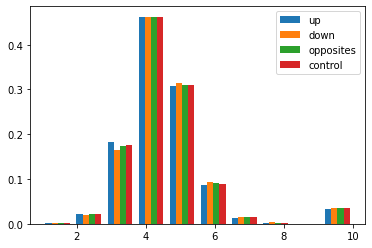

In [213]:
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='value', significance_threshold=0)
# sample_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, 
#                           no_path_penalty=10)
full_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, no_path_penalty=10)

overactivated proteins: 11, underactivated proteins: 35, rest: 905
mean distances: up nodes: 5.16, down nodes: 4.03, opposite nodes: 4.55, control: 4.47
p-values: up: 5.31e-07, down: 9.35e-16, opposite: 1.17e-03


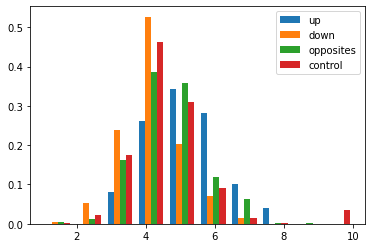

In [214]:
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='std', significance_threshold=2)
# sample_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, 
#                           no_path_penalty=10)
full_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, no_path_penalty=10)

overactivated proteins: 102, underactivated proteins: 108, rest: 741
mean distances: up nodes: 4.43, down nodes: 4.44, opposite nodes: 4.45, control: 4.47
p-values: up: 1.14e-01, down: 1.45e-03, opposite: 4.79e-02


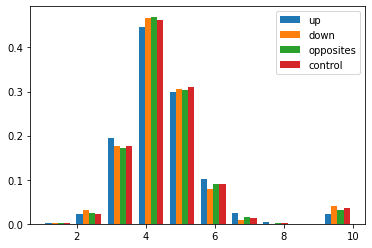

In [215]:
up_proteins, down_proteins = get_up_down_sets(phospho_measure_values,
                                              significance_mode='std', significance_threshold=1)
# sample_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, 
#                           no_path_penalty=10)
full_pair_dist_analysis(phospho_measure_values, up_proteins, down_proteins, random_iter=100000, no_path_penalty=10)